In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pathlib
import sys

In [2]:
# go to parent directory
os.chdir("..")
import paths

REPO_DIR = paths.get_repo_path()
ROOT_DIR = REPO_DIR / "MNIST-Digit_Recogonizer"

# set path to repo_dir
os.chdir(REPO_DIR)

## Data

### Load MNIST data

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Image scaling to 0-1
train_images = train_images / 255.0
test_images = test_images / 255.0

### Displaying the first image in the training set

In [4]:
# display images in a grid function
def display_image_grid(images, labels, pred_val=None,shape=(5, 5), figsize=(10, 10)):
    plt.figure(figsize=figsize)
    m = shape[0] * shape[1]
    
    if images.shape[0] < m:
        raise ValueError("images.shape[0] must equal shape[0] * shape[1]")
    
    if labels.shape[0] != images.shape[0]:
        raise ValueError("labels.shape[0] must equal images.shape[0]")
    
    if pred_val is not None and pred_val.shape[0] != images.shape[0]:
        raise ValueError("pred_val.shape[0] must equal images.shape[0]")
    
    for i in range(m):
        plt.subplot(shape[0], shape[1], i+1)
        plt.imshow(images[i], cmap="gray", interpolation="none")
        title = labels[i]
        if pred_val is not None:
            title = f"{pred_val[i]}"
            if pred_val[i] != labels[i]:
                title += f"(incorrect, {labels[i]})"
        plt.title(title)
        plt.axis("off")
    plt.show()
    

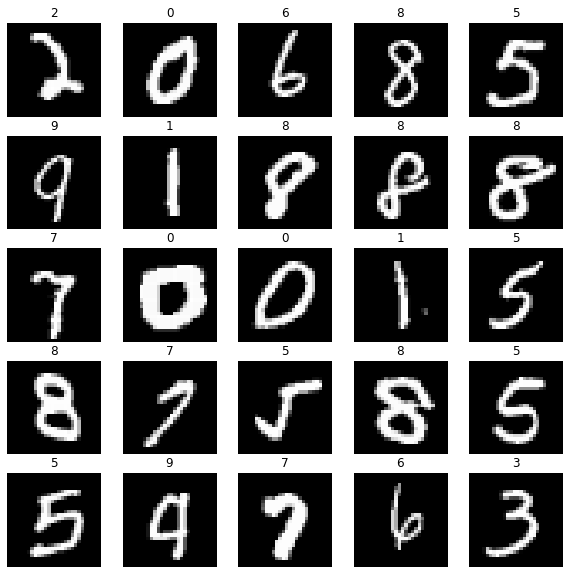

In [5]:
# display 25 random images from the training set
rnd_pts = np.random.randint(0, train_images.shape[0], 25)
images = train_images[rnd_pts, :, :]
labels = train_labels[rnd_pts]

display_image_grid(images, labels)

### Preprocessing the data

In [6]:
# Reshaping the images to a 4D tensor
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

In [7]:
# One hot encode the labels
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

## MODELS

In [8]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Normalization

In [9]:
MODELS_PATH = ROOT_DIR / "models"

In [10]:
def predict_label(images, model):
    predictions = model.predict(images)
    return predictions.argmax(axis=1)

### Create Models

#### Simple Sequential Model

In [11]:
from tensorflow.keras.models import Sequential

def simple_sequential_model(input_shape):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


### Training

In [12]:
# ploting the model training history

def plot_model_performance(history, figsize=(10, 10)):
    preformance = {key: val for key, val in history.history.items() if "loss" not in key}
    losses = {key: val for key, val in history.history.items() if "loss" in key}
    
    plt.figure(figsize=figsize)
    plt.title('Model Performance')
    for key, val in preformance.items():
        plt.plot(val, label=key)
    plt.legend(preformance.keys())
    plt.xlabel('Epoch')
    
    plt.figure(figsize=figsize)
    plt.title('Model Losses')
    for key, val in losses.items():
        plt.plot(val, label=key)
    plt.legend(losses.keys())
    plt.xlabel('Epoch')
    
    plt.show()


#### Simple Sequential Model

In [13]:
model = simple_sequential_model(input_shape=(28, 28, 1))
model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                              

2022-06-09 06:23:20.380496: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-09 06:23:20.380734: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
# callbacks
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

# Early stopping
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=7, mode='max')
# learning rate scheduler
lrd = LearningRateScheduler(lambda epoch: 1 / 10**(3 + epoch // 5))
# model checkpoint
mdl_check = ModelCheckpoint(filepath=f'{MODELS_PATH}/simple_sequential.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [15]:
history = model.fit(train_images, y_train, 
                    epochs=30, batch_size=64,
                    validation_split=0.2, callbacks=[es, lrd, mdl_check])

Epoch 1/30


2022-06-09 06:23:20.907735: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-09 06:23:21.142608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


746/750 [============================>.] - ETA: 0s - loss: 0.3177 - accuracy: 0.9016

2022-06-09 06:23:31.405732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.98075, saving model to /Users/vineetmahajan/Code/AI/Projects/Hello/Hello-CNN/MNIST-Digit_Recogonizer/models/simple_sequential.h5
750/750 [==============================] - 12s 15ms/step - loss: 0.3166 - accuracy: 0.9021 - val_loss: 0.0673 - val_accuracy: 0.9807 - lr: 0.0010
Epoch 2/30
747/750 [============================>.] - ETA: 0s - loss: 0.0872 - accuracy: 0.9754
Epoch 2: val_accuracy improved from 0.98075 to 0.98692, saving model to /Users/vineetmahajan/Code/AI/Projects/Hello/Hello-CNN/MNIST-Digit_Recogonizer/models/simple_sequential.h5
750/750 [==============================] - 11s 14ms/step - loss: 0.0871 - accuracy: 0.9755 - val_loss: 0.0528 - val_accuracy: 0.9869 - lr: 0.0010
Epoch 3/30
750/750 [==============================] - ETA: 0s - loss: 0.0618 - accuracy: 0.9823
Epoch 3: val_accuracy improved from 0.98692 to 0.98792, saving model to /Users/vineetmahajan/Code/AI/Projects/Hello/Hello-CNN/MNIST-Digit_Recogonizer/models/simpl

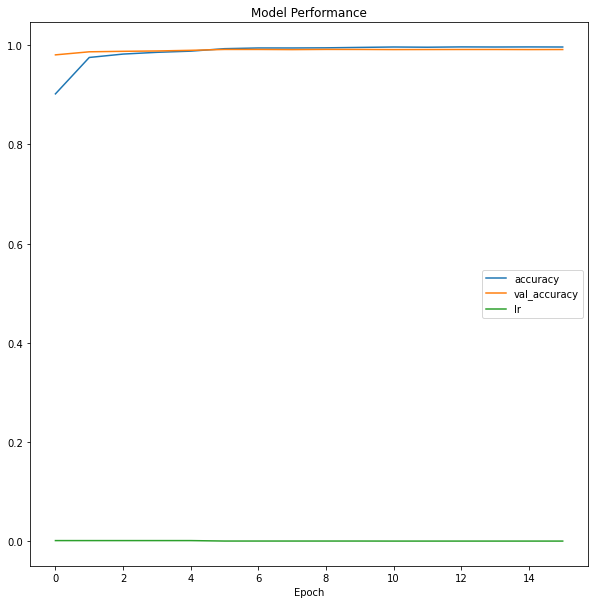

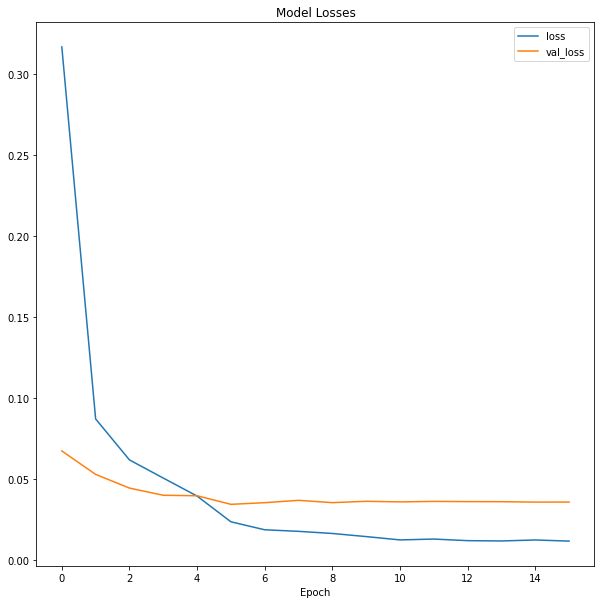

In [16]:
plot_model_performance(history)

In [17]:
model.evaluate(test_images, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.0244 - accuracy: 0.9930


[0.024366158992052078, 0.9930000305175781]

## Testing Performance

In [18]:
from sklearn.metrics import confusion_matrix, classification_report 

def confusion_matrix_plot(y_test, y_pred, figsize=(12, 10)):
    plt.figure(figsize=figsize)
    cm = confusion_matrix(y_test, y_pred)
    cm_plot = sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu")
    cm_plot.set_title('Confusion Matrix')
    cm_plot.set_xlabel('Predicted Label')
    cm_plot.set_ylabel('True Label')
    plt.show()
    
def classification_report_plot(y_test, y_pred, figsize=(12, 10)):
    plt.figure(figsize=figsize)
    cr = classification_report(y_test, y_pred, output_dict=True)
    cr_heatmap = sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True, cmap="YlGnBu", fmt='.2f')
    cr_heatmap.set_title('Classification Report')
    cr_heatmap.set_xlabel('Metrics')
    cr_heatmap.set_ylabel('Classes')
    plt.show()

### Simple Sequential Model

In [19]:
from tensorflow.keras.models import load_model
model = load_model(f'{MODELS_PATH}/simple_sequential.h5')

#### Performance Heatmap

2022-06-09 06:26:15.115323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy: 0.9926


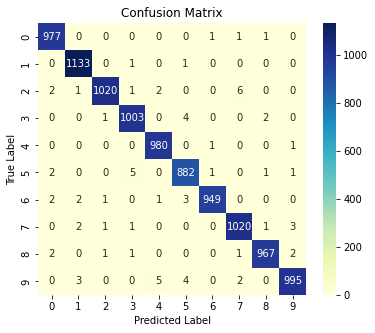

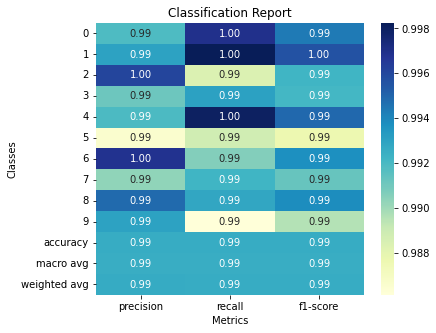

In [20]:
#  confusion matrix and classification report
from sklearn.metrics import accuracy_score

x, y = test_images, test_labels
test_labels_pred = predict_label(x, model)
print("Accuracy:", accuracy_score(y, test_labels_pred))
confusion_matrix_plot(y, test_labels_pred, figsize=(6, 5))
classification_report_plot(y, test_labels_pred, figsize=(6, 5))


#### Data Visualization

In [21]:
# rnd_pts = np.random.randint(0, test_images.shape[0], 25)
# images = test_images[rnd_pts, :, :]
# labels = test_labels[rnd_pts]
# labels_pred  = test_labels_pred[rnd_pts]

# display_image_grid(images, labels, labels_pred)


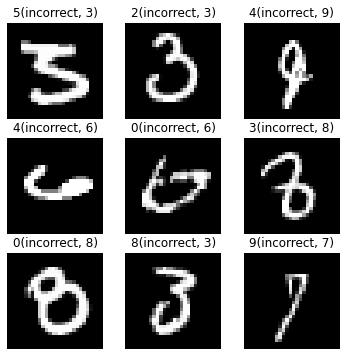

In [22]:
# Plotting only the incorrect images

labels_pred = predict_label(test_images, model)
incorrect_pred = test_labels != labels_pred

rnd_pts = np.random.randint(0, incorrect_pred.sum(), 9)

images = test_images[incorrect_pred, :, :][rnd_pts, :, :]
labels = test_labels[incorrect_pred][rnd_pts]
labels_pred = labels_pred[incorrect_pred][rnd_pts]

display_image_grid(images, labels, labels_pred, figsize=(6, 6), shape=(3, 3))

## Results

### 99.1% is good enough accuracy, no need to apply any more models...

### Simple Sequential Model with Dropout

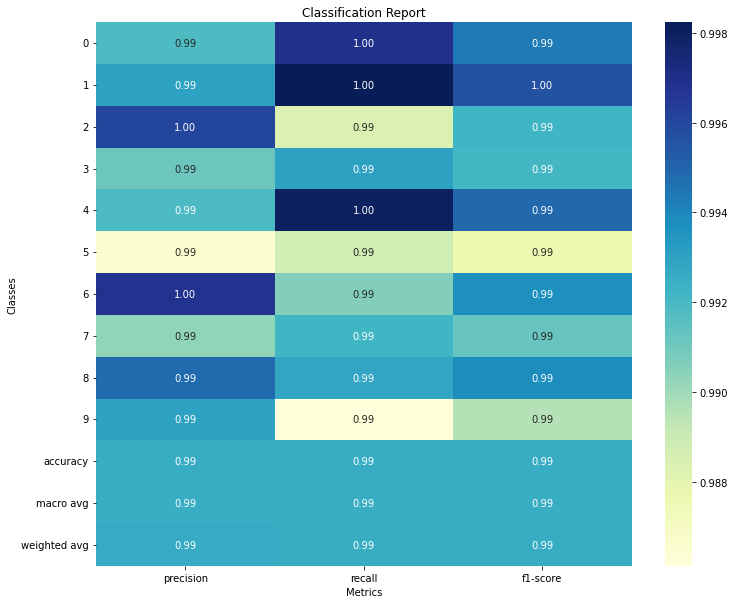

In [27]:
classification_report_plot(y, test_labels_pred)